# 로지스틱
- toc:true
- branch: master
- badges: true
- comments: true
- editor : 이강철
- hide : false
- published : true

$$ y \sim Beru(p)\quad \quad  p =\frac {1}{ 1+e^{-\hat y}} $$

## Not keras + GradientTape

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.experimental.numpy as tnp
import numpy as np

In [ ]:
tnp.experimental_enable_numpy_behavior()

*  $w_0 = -1,w_1 = 5$인 로지스틱 모형을 적합한다고 하자.

In [ ]:
N = 2000
x = tnp.linspace(-1,1,N)
w0 = -1
w1 =  5

u = w0+w1*x
v = tf.nn.sigmoid(u)

y = tf.constant(np.random.binomial(1,v),dtype="float64")

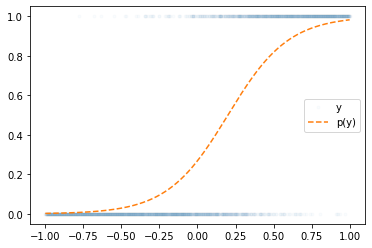

In [ ]:
plt.plot(x,y,".",alpha=0.02)
plt.plot(x,v,"--")
plt.legend(["y","p(y)"])

* 초기 베타값 설정

In [ ]:
_w0 = tf.Variable(-10.0,dtype="float64")
_w1 = tf.Variable(-1.0,dtype="float64")

In [ ]:
alpha=0.1

In [ ]:
for i in range(1000) : 
    with tf.GradientTape() as tape:
          u = _w0+_w1*x
          yhat = tf.nn.sigmoid(u)
          bce_loss = -tf.reduce_mean(y*tnp.log(yhat) + (1-y)*tnp.log(1-yhat))
    slope0,slope1 = tape.gradient(bce_loss,[_w0,_w1])
    _w0.assign_sub(alpha*slope0)
    _w1.assign_sub(alpha*slope1)

In [ ]:
_w0,_w1

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-1.015976308833959>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.644966488591715>)

In [ ]:
u = _w0+_w1*x
yhat = tf.nn.sigmoid(u)

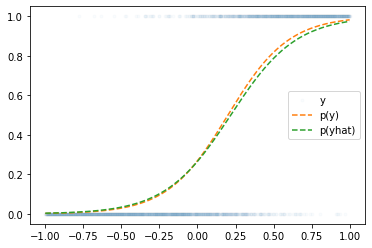

In [ ]:
plt.plot(x,y,".",alpha=0.02)
plt.plot(x,v,"--")
plt.plot(x,yhat,"--")
plt.legend(["y","p(y)","p(yhat)"])

## Keras + BCE

In [ ]:
net =tf.keras.Sequential()
l1  = tf.keras.layers.Dense(1,input_shape=(1,),use_bias=True,activation = "sigmoid")
net.add(l1)

net.compile(tf.optimizers.SGD(0.1),loss="binary_crossentropy")
net.fit(x,y,epochs=1000,verbose=0,batch_size=N)

In [ ]:
net.weights

[<tf.Variable 'dense_4/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[4.3315763]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(1,) dtype=float32, numpy=array([-0.9468348], dtype=float32)>]

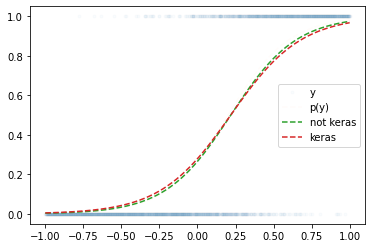

In [ ]:
plt.plot(x,y,".",alpha=0.02)
plt.plot(x,v,"--",alpha=0.02)
plt.plot(x,yhat,"--")
plt.plot(x,net(x),"--")
plt.legend(["y","p(y)","not keras","keras"])

## Keras + MSE 

In [ ]:
net2 =tf.keras.Sequential()
l1  = tf.keras.layers.Dense(1,input_shape=(1,),use_bias=True,activation = "sigmoid")
net2.add(l1)

net2.compile(tf.optimizers.SGD(0.1),loss="mse")
net2.fit(x,y,epochs=1000,verbose=0,batch_size=N)

In [ ]:
net2.weights

[<tf.Variable 'dense_5/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[3.1830382]], dtype=float32)>,
 <tf.Variable 'dense_5/bias:0' shape=(1,) dtype=float32, numpy=array([-0.68770933], dtype=float32)>]

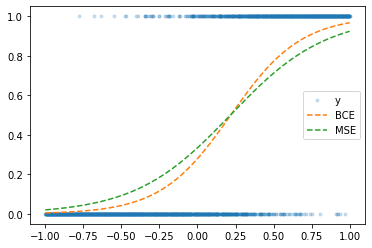

In [ ]:
plt.plot(x,y,".",alpha=0.2)
plt.plot(x,net(x),"--")
plt.plot(x,net2(x),"--")
plt.legend(["y","BCE","MSE"])

* `MSE` 의 경우  초기 기울기가 크지 않아 `loss`가 0으로 가는 수렴 속도가 매우 느리다.

* 즉, 동일한 기준에서 `BCE`가 성능이 더좋다.

## Adam

* `Adam`을 쓰면 손실함수 미분 시 자동으로 scale을 조정해주고 계산된 기울기 값을 누적시켜 `MSE`도 `loss=0`의 빠르게 수렴한다.

* 그렇다면 걍 MSE 쓰고 `Adam`을 쓰면 되지 않냐??

* 답은 놉 : `Adam`이라고 해도 초기값 설정이 안좋으면 지역해에서 빠져나오기 힘들다.(그래도 만약 MSE가 convex 하다면 학습률을 적절히 조절해줄 경우 글로벌미니멈을 잘 찾을 수 있음)

#### Adam + MSE

In [ ]:
net3 =tf.keras.Sequential()
l1  = tf.keras.layers.Dense(1,input_shape=(1,),use_bias=True,activation = "sigmoid")
net3.add(l1)

net3.compile(tf.optimizers.Adam(0.1),loss="mse")
net3.fit(x,y,epochs=1000,verbose=0,batch_size=N)

In [ ]:
net4 =tf.keras.Sequential()
l1  = tf.keras.layers.Dense(1,input_shape=(1,),use_bias=True,activation = "sigmoid")
net4.add(l1)

net4.compile(tf.optimizers.Adam(0.1),loss="binary_crossentropy")
net4.fit(x,y,epochs=1000,verbose=0,batch_size=N)

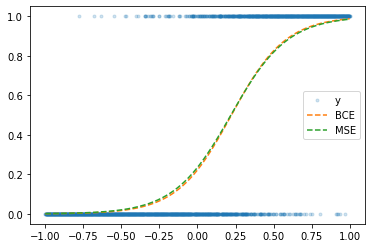

In [ ]:
plt.plot(x,y,".",alpha=0.2)
plt.plot(x,net3(x),"--")
plt.plot(x,net4(x),"--")
plt.legend(["y","BCE","MSE"])

#### Adam + MSE(초기값 변경)

In [ ]:
X = tf.stack([tf.ones(N,dtype="float64"),x],axis=1)
y = y.reshape(N,1)

In [ ]:
net3 =tf.keras.Sequential()
l1  = tf.keras.layers.Dense(1,use_bias=False,activation = "sigmoid")
net3.add(l1)

net3.compile(tf.optimizers.Adam(0.1),loss="mse")
net3.fit(X,y,epochs=1,verbose=0,batch_size=N)

In [ ]:
net4 =tf.keras.Sequential()
l1  = tf.keras.layers.Dense(1,use_bias=False,activation = "sigmoid")
net4.add(l1)

net4.compile(tf.optimizers.Adam(0.1),loss="binary_crossentropy")
net4.fit(X,y,epochs=1,verbose=0,batch_size=N)

In [ ]:
net3.set_weights([tnp.array([[-10.0 ],[ -1.0]],dtype=tf.float32)])
net4.set_weights([tnp.array([[-10.0 ],[ -1.0]],dtype=tf.float32)])

In [ ]:
net3.fit(X,y,epochs=1000,verbose=0,batch_size=N)
net4.fit(X,y,epochs=1000,verbose=0,batch_size=N)

In [ ]:
net3.weights,net4.weights

([<tf.Variable 'dense_28/kernel:0' shape=(2, 1) dtype=float32, numpy=
  array([[-10.146577  ],
         [ -0.13052957]], dtype=float32)>],
 [<tf.Variable 'dense_29/kernel:0' shape=(2, 1) dtype=float32, numpy=
  array([[-1.1787033],
         [ 5.3664837]], dtype=float32)>])

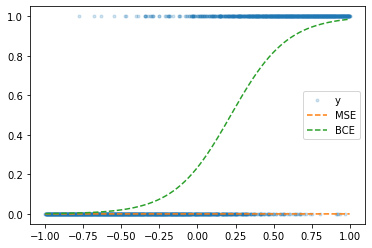

In [ ]:
plt.plot(x,y,".",alpha=0.2)
plt.plot(x,net3(X),"--")
plt.plot(x,net4(X),"--")
plt.legend(["y","MSE","BCE"])

* 보이는 바와 같이 `MSE`의 경우 지역해에 빠져 나오지 못한 모습을 보여준다.

* 따라서 옵티마이저를 먼저 선정하기 전에 적절한 손실함수가 선정이 우선시 되어야 한다.!!